Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [16]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [7]:
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path("Test")

In [8]:
# Count the number of images in the train and test directories
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Number of training images: {image_count_train}")

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Number of test images: {image_count_test}")

Number of training images: 2239
Number of test images: 118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [35]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="training",validation_split=0.2)

Found 9739 files belonging to 9 classes.
Using 7792 files for training.


In [36]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="validation",validation_split=0.2)

Found 9739 files belonging to 9 classes.
Using 1947 files for validation.


In [37]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

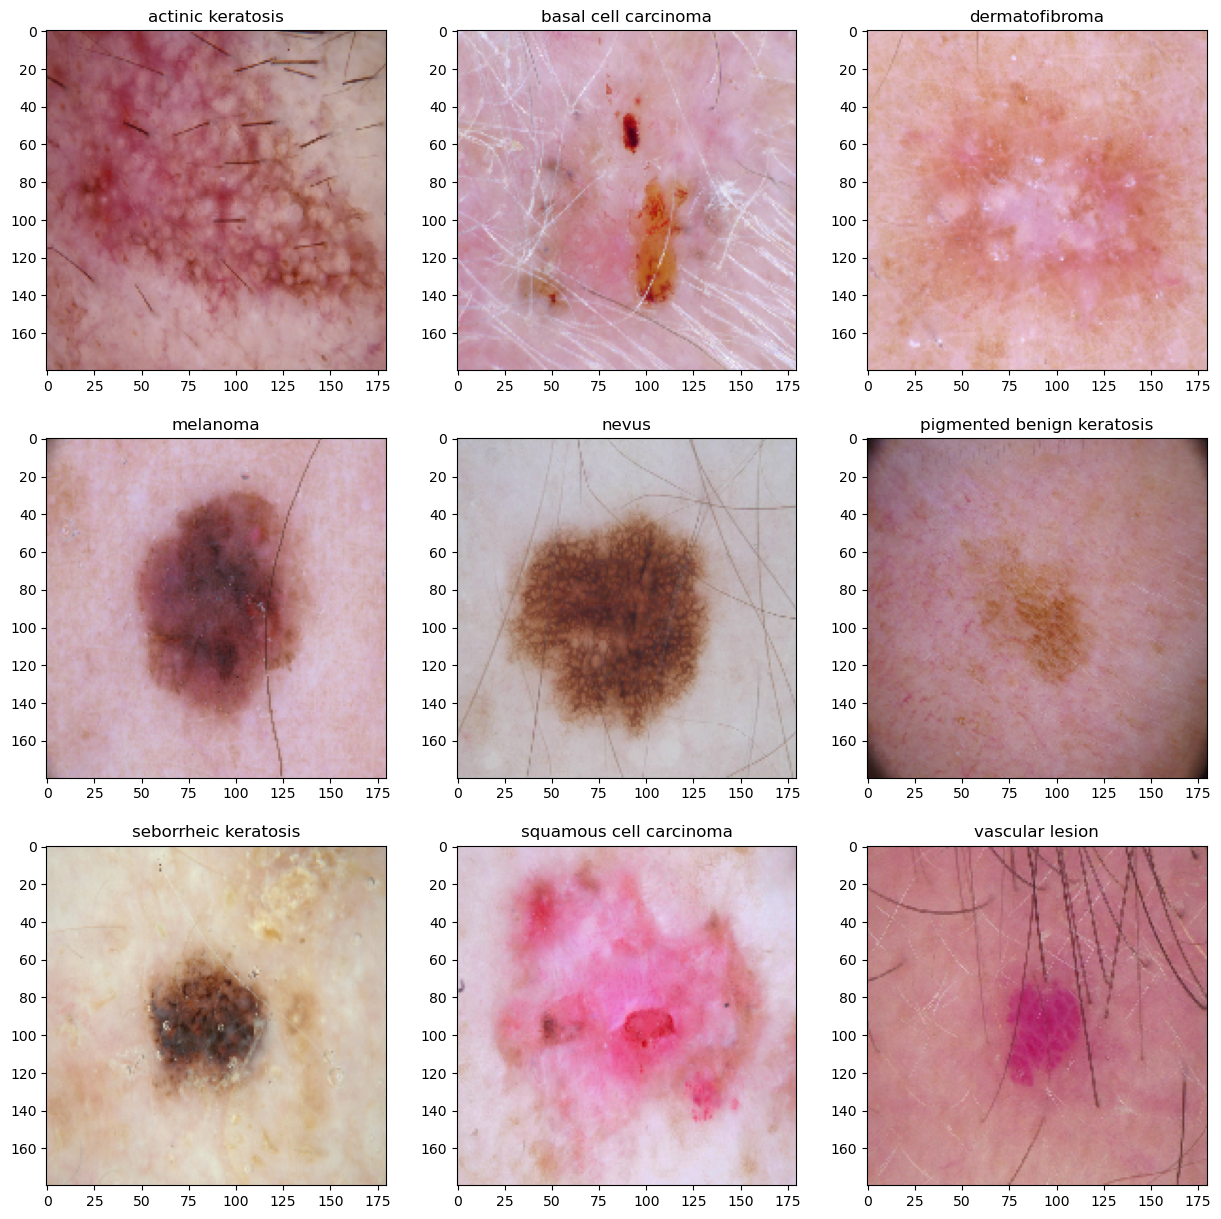

In [38]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
files_path_dict = {}

for name in class_names:
    files_path_dict[name] = list(map(lambda x:str(data_dir_train)+'/'+name+'/'+x,os.listdir(str(data_dir_train)+'/'+name)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for name in class_names:
    path_list = files_path_dict[name][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(name)
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [40]:
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer
#model.add(data_augmentation)

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [41]:
#Compile the Model

from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [42]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [43]:
# vizualizing the model
#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [47]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 157s 618ms/step - accuracy: 0.2760 - loss: 1.9283 - val_accuracy: 0.3672 - val_loss: 1.6141
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 171s 699ms/step - accuracy: 0.4404 - loss: 1.4543 - val_accuracy: 0.5419 - val_loss: 1.2905
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 183s 751ms/step - accuracy: 0.5602 - loss: 1.2093 - val_accuracy: 0.6276 - val_loss: 1.1335
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 171s 699ms/step - accuracy: 0.6183 - loss: 1.0803 - val_accuracy: 0.6841 - val_loss: 0.9662
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 168s 687ms/step - accuracy: 0.6670 - loss: 0.9697 - val_accuracy: 0.7119 - val_loss: 0.8542
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 177s 727ms/step - accuracy: 0.7202 - loss: 0.8230 - val_accuracy: 0.7437 - val_loss: 0.7928
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 178s 731ms/step - accuracy: 0.7255 - loss: 0.7698 - val_accuracy: 0.7838 - val_loss: 0.6999
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 184s 755ms/step - accuracy: 0.7687 -

### Visualizing training results

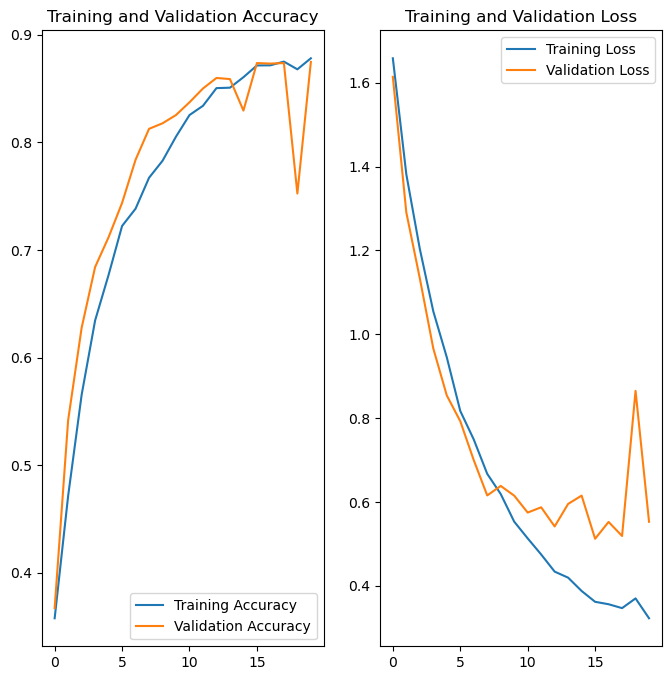

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The model is overfitting as we can see huge difference between training and validation loss function.

The accuracy is between 85-90% which is quite good in both training and validation dataset.

We can analyse and train the model to draw final conclusion if model is underfit or overfit.

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here



### Compiling the model

In [ ]:
## Your code goes here

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = ## your training code

### Visualizing the results

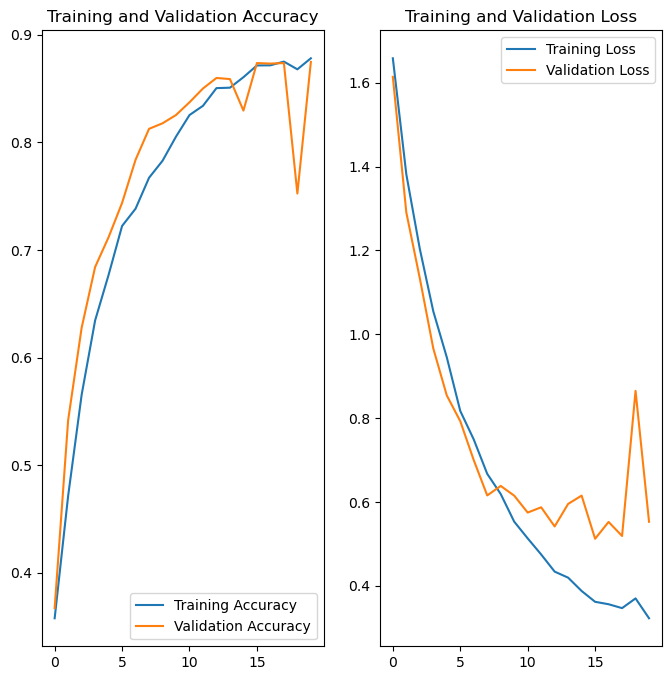

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [79]:
## The model is overfitting as we can see huge difference between training and validation loss function.

class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff._append({'class':name,'number':number},ignore_index=True)

class_diff
     

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [51]:
## Your code goes here.
import os
from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [52]:
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis'), ('Train\\actinic keratosis\\ISIC_0025825.jpg', 'actinic keratosis'), ('Train\\actinic keratosis\\ISIC_0025953.jpg', 'actinic keratosis'), ('Train\\actinic keratosis\\ISIC_0025957.jpg', 'actinic keratosis')]


In [53]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis


In [55]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [41]:
!pip install Augmentor

In [56]:

path_to_training_dataset= pathlib.Path("Train")
for class_name in class_names:
    # Use the / operator to create the full path for the class
    class_path = path_to_training_dataset / class_name
    p = Augmentor.Pipeline(str(class_path))  # Convert Path to string for Augmentor
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Generate 500 augmented samples

Initialised with 114 image(s) found.
Output directory set to Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x221351E80D0>: 100%|██████████| 500/500 [00:02<00:00, 234.28 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2212947B8D0>: 100%|██████████| 500/500 [00:02<00:00, 216.42 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22129E446D0>: 100%|██████████| 500/500 [00:02<00:00, 221.88 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x22129476690>: 100%|██████████| 500/500 [00:20<00:00, 24.86 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x22129C21A50>: 100%|██████████| 500/500 [00:21<00:00, 23.28 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to Train\pigmented benign keratosis\output.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]


AttributeError: 'FileNotFoundError' object has no attribute 'message'

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [57]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

10000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [61]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0a9f31ea-7b80-4aaa-a0c3-cc933a10fd6d.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0c81cf6b-cb83-468e-92f7-830b8ff1f233.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_15b26732-c75c-4ceb-a383-19785a2fc8da.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2e69acba-3dea-446c-870a-3e19bd85fe03.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_583a079d-b49e-419e-ba9b-53556c1b3db9.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7ddbbc41-8c79-4abc-8027-d59c59cec79d.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_89d41edd-406f-449f-9e93-9b7b88beb3b1.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a58b82a8-7ce8-426a-8781-951de13c1c5e.jpg',
 'Train\\actinic

In [62]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [63]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [64]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
#new_df = lesions_df.append(df2)
#new_df.shape
new_df = pd.concat([lesions_df, df2], ignore_index=True)

In [65]:
new_df.head()

,Image Path,Label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis


In [66]:
new_df['Label'].value_counts()

Label
melanoma                      2438
basal cell carcinoma          2376
nevus                         2357
actinic keratosis             2114
dermatofibroma                2095
pigmented benign keratosis     462
squamous cell carcinoma        181
vascular lesion                139
seborrheic keratosis            77
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [67]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [68]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12239 files belonging to 9 classes.
Using 9792 files for training.


#### **Todo:** Create a validation dataset

In [69]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12239 files belonging to 9 classes.
Using 2447 files for validation.


In [71]:
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

#### **Todo:** Create your model (make sure to include normalization)

In [72]:
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer
model.add(augmentation_data)

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [76]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [77]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


C:\Users\VijayMishra\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


306/306 ━━━━━━━━━━━━━━━━━━━━ 255s 828ms/step - accuracy: 0.2673 - loss: 1.9160 - val_accuracy: 0.4855 - val_loss: 1.3964
Epoch 2/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 245s 800ms/step - accuracy: 0.4767 - loss: 1.3716 - val_accuracy: 0.5313 - val_loss: 1.3297
Epoch 3/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 248s 809ms/step - accuracy: 0.5237 - loss: 1.2949 - val_accuracy: 0.5464 - val_loss: 1.2918
Epoch 4/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 276s 900ms/step - accuracy: 0.5564 - loss: 1.2481 - val_accuracy: 0.5836 - val_loss: 1.1683
Epoch 5/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.5739 - loss: 1.1829 - val_accuracy: 0.6150 - val_loss: 1.1210
Epoch 6/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 244s 798ms/step - accuracy: 0.5863 - loss: 1.1642 - val_accuracy: 0.6485 - val_loss: 1.0634
Epoch 7/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 241s 785ms/step - accuracy: 0.6042 - loss: 1.1090 - val_accuracy: 0.6579 - val_loss: 1.0266
Epoch 8/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 247s 807ms/step - accuracy: 0.6217 - loss: 1.0788 

#### **Todo:**  Visualize the model results

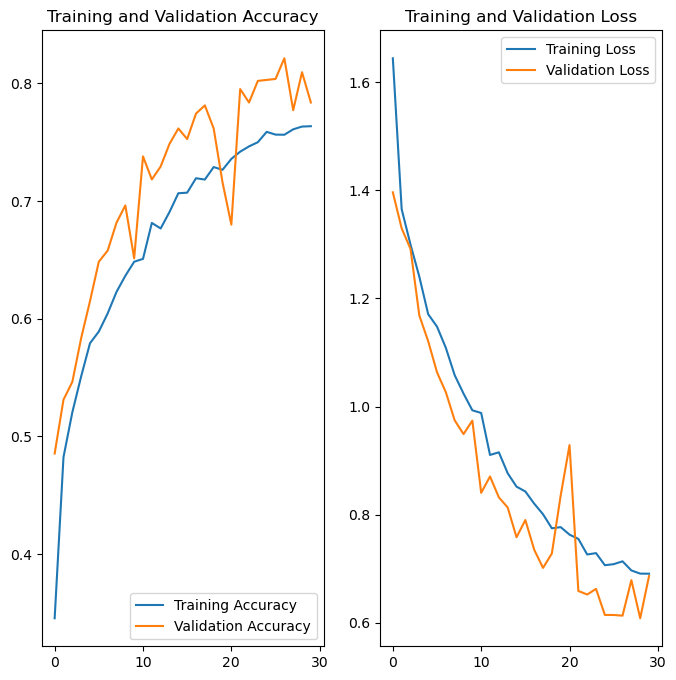

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

